In [ ]:
#hide
from utils import *

# Improving training stability

In [ ]:
path = untar_data(URLs.MNIST)

In [ ]:
#hide
Path.BASE_PATH = path

In [ ]:
path.ls()

(#2) [Path('testing'),Path('training')]

In [ ]:
def get_dls(bs=64):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
        get_items=get_image_files, 
        splitter=GrandparentSplitter('training','testing'),
        get_y=parent_label,
        batch_tfms=Normalize()
    ).dataloaders(path, bs=bs)

dls = get_dls()

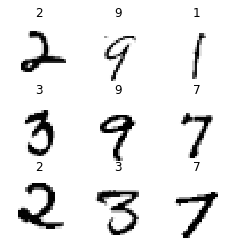

In [ ]:
dls.show_batch(max_n=9, figsize=(4,4))

## A simple baseline

In [ ]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [ ]:
def simple_cnn():
    return sequential(
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        Flatten(),
    )

In [ ]:
from fastai2.callback.hook import *

In [ ]:
def fit(epochs=1):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit(epochs, 0.06)
    return learn

In [ ]:
learn = fit()

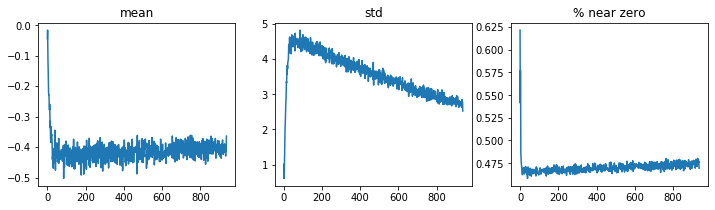

In [ ]:
learn.activation_stats.plot_layer_stats(0)

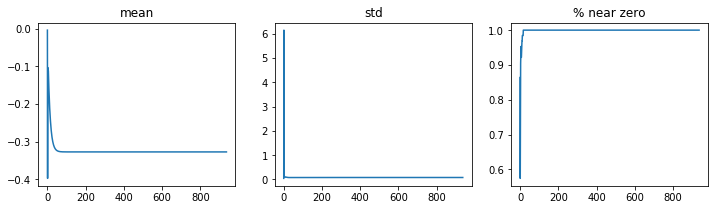

In [ ]:
learn.activation_stats.plot_layer_stats(-2)

## Increase batch size

In [ ]:
dls = get_dls(512)

In [ ]:
learn = fit()

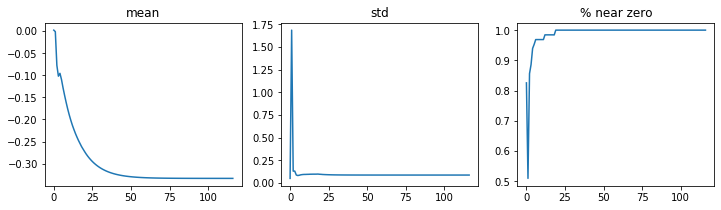

In [ ]:
learn.activation_stats.plot_layer_stats(-2)

## 1cycle training

In [ ]:
def fit(epochs=1, lr=0.06):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr)
    return learn

In [ ]:
learn = fit()

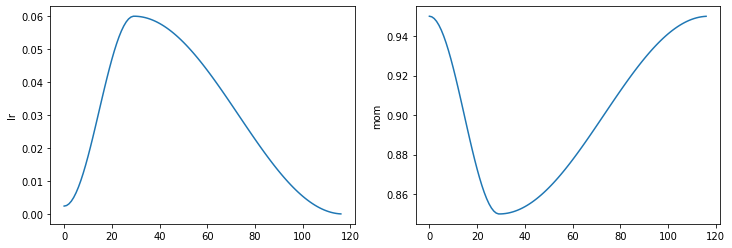

In [ ]:
learn.recorder.plot_sched()

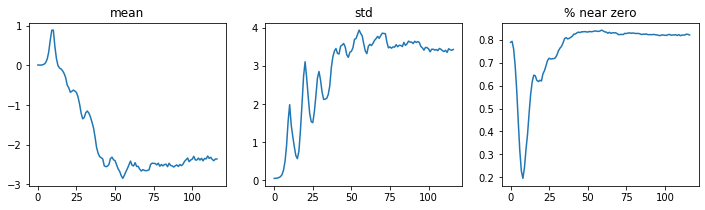

In [ ]:
learn.activation_stats.plot_layer_stats(-2)

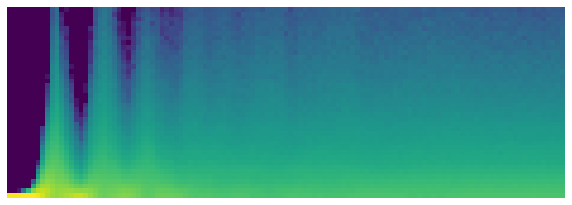

In [ ]:
learn.activation_stats.color_dim(-2)

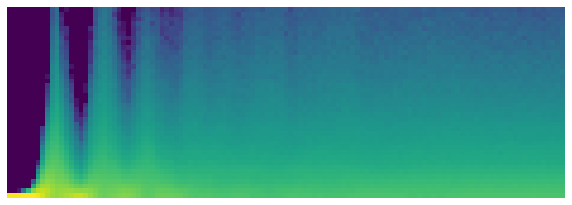

In [ ]:
learn.activation_stats.color_dim(-2)

## Batch normalization

In [ ]:
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

In [ ]:
learn = fit()

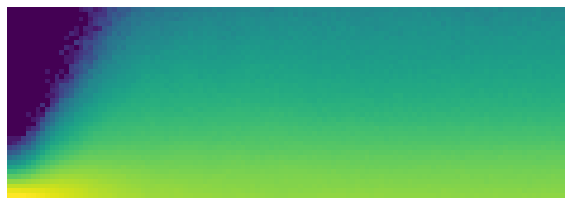

In [ ]:
learn.activation_stats.color_dim(-4)

In [ ]:
learn = fit(5, lr=0.1)